This is the <a href="https://jupyter.org/">Jupyter Notebook</a>, an interactive coding and computation environment. For this lab, you do not have to write any code, you will only be running it. 

To use the notebook:
- "Shift + Enter" runs the code within the cell (so does the forward arrow button near the top of the document)
- You can alter variables and re-run cells
- If you want to start with a clean slate, restart the Kernel either by going to the top, clicking on Kernel: Restart, or by "esc + 00" (if you do this, you will need to re-run the following block of code before running any other cells in the notebook) 

This notebook uses code adapted from 

SimPEG
- Cockett, R., S. Kang, L.J. Heagy, A. Pidlisecky, D.W. Oldenburg (2015, in review), SimPEG: An open source framework for simulation and gradient based parameter estimation in geophysical applications. Computers and Geosciences

In [1]:
from library.Mag import *
from SimPEG import PF, Utils, Mesh
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.sparse.linalg import bicgstab
from SimPEG.Utils import mkvc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['griddata']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# How do we define direction of an earth magnetic field?

Earth magnetic field is a vector. To define a vector we need to choose a coordinate system. We use right-handed system: 
- X (Easting), 
- Y (Northing), and 
- Z (Up). 

Here we consider an earth magnetic field ($\vec{B_0}$), of which intensity is one. To define this unit vector, we use inclinatino and declination:
- Declination: An angle from geographic North (Ng) (positive clockwise)
- Inclination: Vertical angle from the N-E plane (positive down)

<img src="https://github.com/geoscixyz/gpgLabs/raw/master/figures/Mag/earthfield.png?raw=true" style="width: 60%; height: 60%"> </img>

# What's data: total field anomaly

We consider a typical form of magnetic data. To illustrate this we consider an suceptible object embedded in the earth. 
Based upon the earth magnetic field ($\vec{B}_0$), this object will generate anomalous magnetic field ($\vec{B}_A$). We define an unit vector $\hat{B}_0$ for the earth field as 
$$ \hat{B}_0 = \frac{\vec{B}_0}{|\vec{B}_0|}$$ 
We measure both earth and anomalous magnetic field such that

$$ \vec{B} = \vec{B}_0 + \vec{B}_A$$

Total field anomaly, $\triangle \vec{B}$ can be defined as

$$  |\triangle \vec{B}| = |\vec{B}|-|\vec{B}_E| $$ 

If $|\vec{B}|\ll|\vec{B}_E|$, then that is total field anomaly $\triangle \vec{B}$ is the projection of the anomalous field onto the direction of the earth field:

$$ |\triangle \vec{B}| \simeq \vec{B}_A \cdot \hat{B}_0=|\vec{B}_A|cos\theta$$ 

<img src="https://github.com/geoscixyz/gpgLabs/raw/master/figures/Mag/totalfieldanomaly.png?raw=true" style="width: 50%; height: 50%">

In [2]:
#Input parameters
fileName = 'http://github.com/geoscixyz/gpgLabs/raw/master/assets/Mag/data/DO27_TMI.dat'
xyzd = np.genfromtxt(fileName, skip_header=3)
B = np.r_[60308, 83.8, 25.4]
survey = Mag.createMagSurvey(xyzd, B)
# View the data and chose a profile
param = Simulator.ViewMagSurvey2D(survey)
display(param)

Data griddind
=======

Before proceeding with the Fourier filters, we need to grid the data.
Several papers comparing the different interpolation methods.
Minimum curvature is often the best for potential fields

In [3]:

# Define a new grid based on data extent
dxdy = 20
xmin, xmax = xyzd[:,0].min(), xyzd[:,0].max()
ymin, ymax = xyzd[:,1].min(), xyzd[:,1].max()

nCx = int((xmax-xmin)/dxdy)
nCy = int((ymax-ymin)/dxdy)

vecCx = xmin+np.cumsum(np.ones(nCx) * dxdy)
vecCy = ymin+np.cumsum(np.ones(nCy) * dxdy)

gridCx, gridCy = np.meshgrid(vecCx, vecCy)

ndat = xyzd.shape[0]
nC = int(nCx*nCy)

A = np.zeros((ndat, ndat))
for i in range(ndat):

    r = (xyzd[i,0] - xyzd[:,0])**2. + (xyzd[i,1] - xyzd[:,1])**2.
    A[i, :] = r.T * (np.log((r.T + 1e-8)**0.5) - 1.)

# Solve system for the weights
w = bicgstab(A, xyzd[:,3], tol=1e-6)

# Compute new solution
# Reformat the line data locations but skip every n points for test

xx = mkvc(gridCx)
yy = mkvc(gridCy)
dMinCurv = np.zeros_like(xx)
for i in range(nC):

    r = (xx[i] - xyzd[:,0])**2. + (yy[i] - xyzd[:,1])**2.
    dMinCurv[i] = np.sum( w[0] * r.T * ( np.log( (r.T + 1e-8)**0.5 ) - 1. ))

dMinCurv = dMinCurv.reshape(gridCx.shape, order='F')

Data plot
=====

Next step we want to plot the data

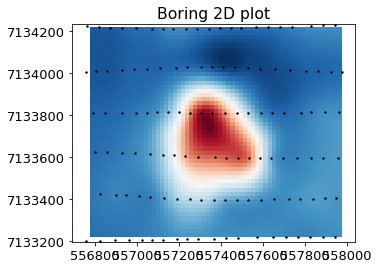

In [48]:
plt.figure()
plt.imshow(dMinCurv, extent=(vecCx[0], vecCx[-1],vecCy[0], vecCy[-1]),origin='lower', cmap='RdBu_r')
plt.scatter(xyzd[:,0], xyzd[:,1],2, color='k')
plt.title('Boring 2D plot')
plt.show()

Advanced plot
=======

We can do better by adding "relief" and sun shading

In [43]:
def plotTopoHillside(X,Y,d_grid, axs=None, fill=True, contour=False, vmin=None, vmax=None,
                     clabel=True, cmap = 'RdBu_r', ve=1., alpha=1., alphaHS=1.,
                     distMax=1000, midpoint=0, azdeg=315, altdeg=45):
    
    ls = LightSource(azdeg=azdeg, altdeg=altdeg)
    
    # Create grid of points
#     x = np.linspace(xyz[:, 0].min(), xyz[:, 0].max(), 1000)
#     y = np.linspace(xyz[:, 1].min(), xyz[:, 1].max(), 1000)

#     X, Y = np.meshgrid(x, y)

    # Interpolate
#     d_grid = griddata(xyz[:, 0:2], xyz[:,2], (X, Y))
    
#     # Remove points beyond treshold
#     tree = cKDTree(xyz[:,:2])
#     xi = _ndim_coords_from_arrays((X, Y), ndim=2)
#     dists, indexes = tree.query(xi)

#     # Copy original result but mask missing values with NaNs
#     d_grid[dists > distMax] = np.nan


    class MidPointNorm(Normalize):    
        def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
            Normalize.__init__(self,vmin, vmax, clip)
            self.midpoint = midpoint

        def __call__(self, value, clip=None):
            if clip is None:
                clip = self.clip

            result, is_scalar = self.process_value(value)

            self.autoscale_None(result)
            vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

            if not (vmin < midpoint < vmax):
                raise ValueError("midpoint must be between maxvalue and minvalue.")       
            elif vmin == vmax:
                result.fill(0) # Or should it be all masked? Or 0.5?
            elif vmin > vmax:
                raise ValueError("maxvalue must be bigger than minvalue")
            else:
                vmin = float(vmin)
                vmax = float(vmax)
                if clip:
                    mask = ma.getmask(result)
                    result = ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                      mask=mask)

                # ma division is very slow; we can take a shortcut
                resdat = result.data

                #First scale to -1 to 1 range, than to from 0 to 1.
                resdat -= midpoint            
                resdat[resdat>0] /= abs(vmax - midpoint)            
                resdat[resdat<0] /= abs(vmin - midpoint)

                resdat /= 2.
                resdat += 0.5
                result = ma.array(resdat, mask=result.mask, copy=False)                

            if is_scalar:
                result = result[0]            
            return result

        def inverse(self, value):
            if not self.scaled():
                raise ValueError("Not invertible until scaled")
            vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

            if cbook.iterable(value):
                val = ma.asarray(value)
                val = 2 * (val-0.5)  
                val[val>0]  *= abs(vmax - midpoint)
                val[val<0] *= abs(vmin - midpoint)
                val += midpoint
                return val
            else:
                val = 2 * (val - 0.5)
                if val < 0: 
                    return  val*abs(vmin-midpoint) + midpoint
                else:
                    return  val*abs(vmax-midpoint) + midpoint

    im, CS= [], []
    if axs is None:
        axs = plt.subplot()
        
    if fill:
        extent = X.min(), X.max(), Y.min(), Y.max()
        im = axs.contourf(X, Y, d_grid, 30, vmin=vmin, vmax=vmax,
                          cmap=cmap, norm=MidPointNorm(midpoint=midpoint), alpha=alpha, antialiased=True)
        
        axs.imshow(ls.hillshade(d_grid, vert_exag=ve, dx=1., dy=1.),
                        cmap='gray_r', alpha=alphaHS,
                        extent=extent, origin='lower')

    if np.any(contour):
        CS = axs.contour(X, Y, d_grid, contour, colors='k', vmin=vmin, vmax=vmax, linewidths=0.5)
        
        if clabel:
            plt.clabel(CS, inline=1, fontsize=10, fmt='%i')
    return im, CS 

In [47]:
import ipywidgets as widgets
def plotData(azdeg,altdeg,alpha,alphaHS):
    fig = plt.figure(figsize=(8,6))
    axs= plt.subplot()

    # Read the data
    vmin, vmax = -25, 150
    cmap = plt.cm.gist_earth

    # Add shading
    im, CS = plotTopoHillside(gridCx, gridCy,dMinCurv ,
                              axs=axs, cmap='RdBu_r', vmin=vmin, vmax=vmax, 
                              clabel=False, 
                              alpha=alpha, alphaHS=alphaHS, ve=1., azdeg=azdeg, altdeg=altdeg)

    # Add points at the survey locations
    plt.scatter(xyzd[:,0], xyzd[:,1], s=2, c='k')

    # Set limits and labels
    axs.set_xlim([xmin,xmax])
    axs.set_ylim([ymin,ymax])
    # axs.set_xticklabels([556750,558000, 559250], size=14)
    # axs.set_xticks([556750,558000, 559250])
    # axs.set_yticklabels([7133000,7134000, 7135000], size=14, rotation=90, va='center')
    plt.colorbar(im)
    # axs.set_yticks([7133000,7134000, 7135000])
    axs.set_xlabel("Easting (m)", size=14)
    axs.set_ylabel("Northing (m)", size=14)
    axs.grid('on', color='k', linestyle='--')
    plt.show()
    # Add colorbar
    # pos = axs.get_position() # Get the position of previous axes
    # axbar = plt.axes([pos.x0+.25, pos.y0+0.2,  pos.width*0.75, pos.height*.5]) # Create a new axes and reshape
    # cbar = plt.colorbar(im, orientation='vertical',format='%.3f') # Add a colorbar using the color definition of previous
    # cbar.set_ticks(np.linspace(-25,300,6)) # Change the tick position
    # cbar.set_ticklabels(np.round(np.linspace(-25,300,6))) # Change the tick labels
    # axbar.text(pos.x0+1., pos.y0+.75,'SI', size=14) # Add units and move it above
    # axbar.axis('off') # Only keep the colorbar, remove the rest

out = widgets.interactive(plotData,
                          azdeg=widgets.FloatSlider(min=0, max=360, step=5, value=0, continuous_update=False),
                          altdeg=widgets.FloatSlider(min=0, max=90, step=5, value=45, continuous_update=False),
                          alpha=widgets.FloatSlider(min=0, max=1, step=0.1, value=0.2, continuous_update=False),
                          alphaHS=widgets.FloatSlider(min=0, max=1, step=0.1, value=1.0, continuous_update=False))

display(out)

Fourier Filters
========

Next we want to look at data filters

1- Total derivative

2- 1th Vertical derivative

In [25]:
# Define the parametric model interactively
model = Simulator.ViewPrism(param.result)
display(model)

# Magnetic applet
Based on the prism that you made above, below Magnetic applet computes magnetic field at receiver locations, and provide both 2D map (left) and profile line (right). 

For the prism, you can alter:
- sus: susceptibility of the prism

Parameters for the earth field are:
- Einc: inclination of the earth field (degree)
- Edec: declination of the earth field (degree)
- Bigrf: intensity of the earth field (nT)

For data, you can view:
- tf: total field anomaly,  
- bx :x-component, 
- by :y-component, 
- bz :z-component

You can simulate and view remanent magnetization effect with parameters:
- irt: "induced", "remanent", or "total"
- Q: Koenigsberger ratio ($\frac{M_{rem}}{M_{ind}}$)
- rinc: inclination of the remanent magnetization (degree)
- rdec: declination of the remanent magnetization (degree)


In [6]:
plotwidget = Simulator.PFSimulator(model, param)
display(plotwidget)